In [1]:
import chromadb
from PIL import Image
from numpy import asarray
from chromadb.utils import embedding_functions
from chromadb.utils.data_loaders import ImageLoader
from transformers import (
    LlamaTokenizer,
    LlamaForCausalLM,
    GenerationConfig,
    pipeline,
    BitsAndBytesConfig,
    CodeGenTokenizer,
)
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from langchain.llms import HuggingFacePipeline
import open_clip
import warnings

warnings.filterwarnings("ignore")

c:\Users\harma\Desktop\Price Discovery\Amazon product 2023\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chroma_client = chromadb.PersistentClient(path="clip_textdb")
collection = chroma_client.get_collection(name="Text_Store")

In [3]:
chroma_client2 = chromadb.PersistentClient(path="product_imagedb")
image_loader = ImageLoader()
multimodal_ef = OpenCLIPEmbeddingFunction()
multimodal_db = chroma_client2.get_or_create_collection(
    name="Image_Store",
    embedding_function=multimodal_ef,
    data_loader=image_loader,
    metadata={"hnsw:space": "cosine"},
)

In [5]:
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-32", pretrained="laion2b_s34b_b79k"
)
tokenizer = open_clip.get_tokenizer(model_name="ViT-B-32")

In [7]:
inp = "Skechers Men's Afterburn M. Fit"
text = tokenizer([inp])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
inp_emb = text_features.tolist()

In [8]:
result = collection.query(
    query_embeddings=inp_emb,
    n_results=5,
    include=["documents", "distances", "metadatas"],
)

In [9]:
result

{'ids': [['B00KOJT7WE',
   'B07KKYSTXK',
   'B00SVYCZ7I',
   'B093PF43D6',
   'B07GLT4RKK']],
 'distances': [[0.841490626335144,
   0.8475877046585083,
   0.8477905988693237,
   0.859974205493927,
   0.8654392957687378]],
 'metadatas': [[{'price': '110.06'},
   {'price': '52.95'},
   {'price': '144'},
   {'price': '59.95'},
   {'price': '90'}]],
 'embeddings': None,
 'documents': [["Men's Woodburn 2 Waterproof Low Rise Hiking Shoes",
   "Men's Versafoam Excursion Tr13 Walking Shoe",
   "Men's Bridger Low B-Dry Waterproof Hiking Shoe",
   "Men's, Accentor 2 Ventilator Hiking Shoe",
   "Merrell Men's Intercept Hiking Shoe"]],
 'uris': None,
 'data': None}

In [10]:
from numpy import asarray


# load the image and convert into
# numpy array - hat.jpg, sunglasses.jpg, bag.jpg, cable.png
img = Image.open(r"test images/Skechers Men's Afterburn M. Fit.webp")

# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = asarray(img)

In [11]:
results = multimodal_db.query(
    query_images=numpydata,
    # query_texts=["Skechers Men's Afterburn M. Fit"],
    n_results=5,
    include=["uris", "metadatas", "distances"],
)

In [12]:
results

{'ids': [['B00EVQ86BY',
   'B0BY453C8D',
   'B0BNW8F7NS',
   'B09QBQQN8R',
   'B000AYVZGE']],
 'distances': [[0.30453526973724365,
   0.3603156507015228,
   0.36398419737815857,
   0.366391122341156,
   0.3786705732345581]],
 'metadatas': [[{'price': '55.17'},
   {'price': '99'},
   {'price': '95'},
   {'price': '66.99'},
   {'price': '42.99'}]],
 'embeddings': None,
 'documents': None,
 'uris': [['images/B00EVQ86BY.jpg',
   'images/B0BY453C8D.jpg',
   'images/B0BNW8F7NS.jpg',
   'images/B09QBQQN8R.jpg',
   'images/B000AYVZGE.jpg']],
 'data': None}

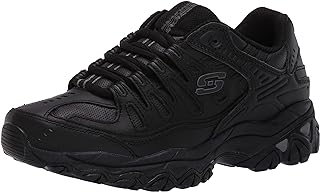

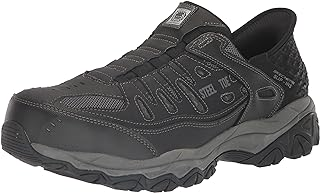

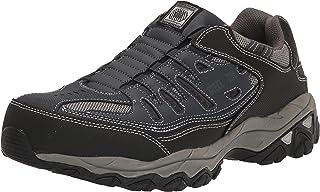

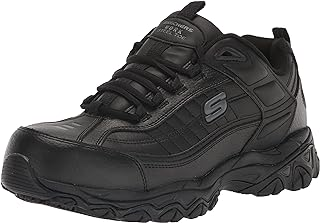

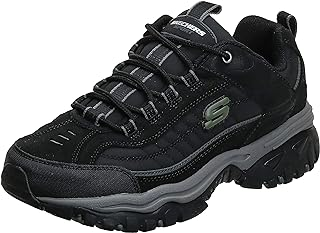

In [13]:
i = results["uris"]
for j in i[0]:
    img2 = Image.open(j)
    display(img2)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
base_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    load_in_8bit=True,
    torch_dtype=torch.float32,
    device_map="auto",
    quantization_config=quantization_config,
)

bin c:\Users\harma\Desktop\Price Discovery\Amazon product 2023\.venv\Lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


Loading checkpoint shards: 100%|██████████| 2/2 [00:25<00:00, 12.67s/it]


In [16]:
pipe = pipeline(
    "text-generation",
    model=base_model,
    tokenizer=tokenizer,
    max_length=256,
    temperature=0.6,
    top_p=0.95,
    repetition_penalty=1.2,
)
local_llm = HuggingFacePipeline(pipeline=pipe)
pipe.model.config.pad_token_id = pipe.model.config.eos_token_id

In [17]:
Data = ""
for i in range(0, 5):
    price = result["metadatas"][0][i]["price"]
    Data += (
        "Distance: " + str(result["distances"][0][i]) + ", Price:" + str(price) + "\n"
    )
for i in range(0, 5):
    price = results["metadatas"][0][i]["price"]
    Data += (
        "Distance: " + str(results["distances"][0][i]) + ", Price:" + str(price) + "\n"
    )

In [19]:
from langchain import PromptTemplate, LLMChain

template = f"""Provide the price range by calculating the median based on the data given in the data section. The product is given in the product section
### Product
{inp}"""
template += """
### Data:
{Data}
Answer:"""
print(template)
prompt = PromptTemplate(template=template, input_variables=["Data"])

Provide the price range by calculating the median based on the data given in the data section. The product is given in the product section
### Product
Skechers Men's Afterburn M. Fit
### Data:
{Data}
Answer:


In [20]:
llm_chain = LLMChain(prompt=prompt, llm=local_llm)
print(llm_chain.run(Data))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 $60-$80



In [21]:
print(Data)

Distance: 0.841490626335144, Price:110.06
Distance: 0.8475877046585083, Price:52.95
Distance: 0.8477905988693237, Price:144
Distance: 0.859974205493927, Price:59.95
Distance: 0.8654392957687378, Price:90
Distance: 0.30453526973724365, Price:55.17
Distance: 0.3603156507015228, Price:99
Distance: 0.36398419737815857, Price:95
Distance: 0.366391122341156, Price:66.99
Distance: 0.3786705732345581, Price:42.99



The improvement areas:
1. Improving the prompts
2. Improving the data by exploring different embeddings from different multimodal llms or looking into Knowledge graph database
3. Enabling / Fine tunning the LLM to be aware of events like Black Friday sale, etc. eg. using agents to search on current market situation
4. Deciding on a suitable evaluation metric that makes sure the range given is suitable and that the price is in the range